# Figure 4: model comparison

In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm

from statsmodels.stats.multitest import multipletests
from himalaya.scoring import correlation_score

from util import plot, subject, stats
from util.path import Path
from util.atlas import Atlas, get_brainmask
from util.stats import ttest_1samp
from constants import SUBS_STRANGERS, BLU, ORG

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
encmodel = "encoding_t9"
model_order = ['contextual', 'acoustic', 'static', 'articulatory', 'syntactic'][::-1]

FG_MASK = get_brainmask()

cache = 'trialmot9'
encmodel, cache

('encoding_t9', 'trialmot9')

In [4]:
cachedir = f"results/cache/figure4-comparison/{cache}/"
!mkdir -p $cachedir
cachedir

'results/cache/figure4-comparison/trialmot9/'

In [5]:
enc_sigmask = np.load('results/cache/figure2-enc/joint/trialmot9/sigmask.npy')

# within-subject encoding comparison

In [6]:
models = ['acoustic', 'articulatory', 'syntactic', 'static', 'contextual']

results = defaultdict(list)
prod_results = defaultdict(list)
comp_results = defaultdict(list)
for modelname in models:
    respath = Path(
        root='results/' + encmodel,
        sub="000",
        datatype=modelname,
        ext=".hdf5",
    )

    for sub in tqdm(SUBS_STRANGERS, desc=modelname):
        respath.update(sub=f"{sub:03d}")
        if not respath.isfile():
            print("skip", sub)
            continue
        with h5py.File(respath, "r") as f:
            results[modelname].append(np.mean(f['cv_scores_prod'][:, -2] + f['cv_scores_comp'][:, -1], axis=0))
            prod_results[modelname].append(np.mean(f['cv_scores_prod'][:, -2], axis=0))
            comp_results[modelname].append(np.mean(f['cv_scores_comp'][:, -1], axis=0))

for modelname in models:
    results[modelname] = np.stack(results[modelname])
    prod_results[modelname] = np.stack(prod_results[modelname])
    comp_results[modelname] = np.stack(comp_results[modelname])

contextual: 100%|██████████| 58/58 [00:00<00:00, 81.88it/s]


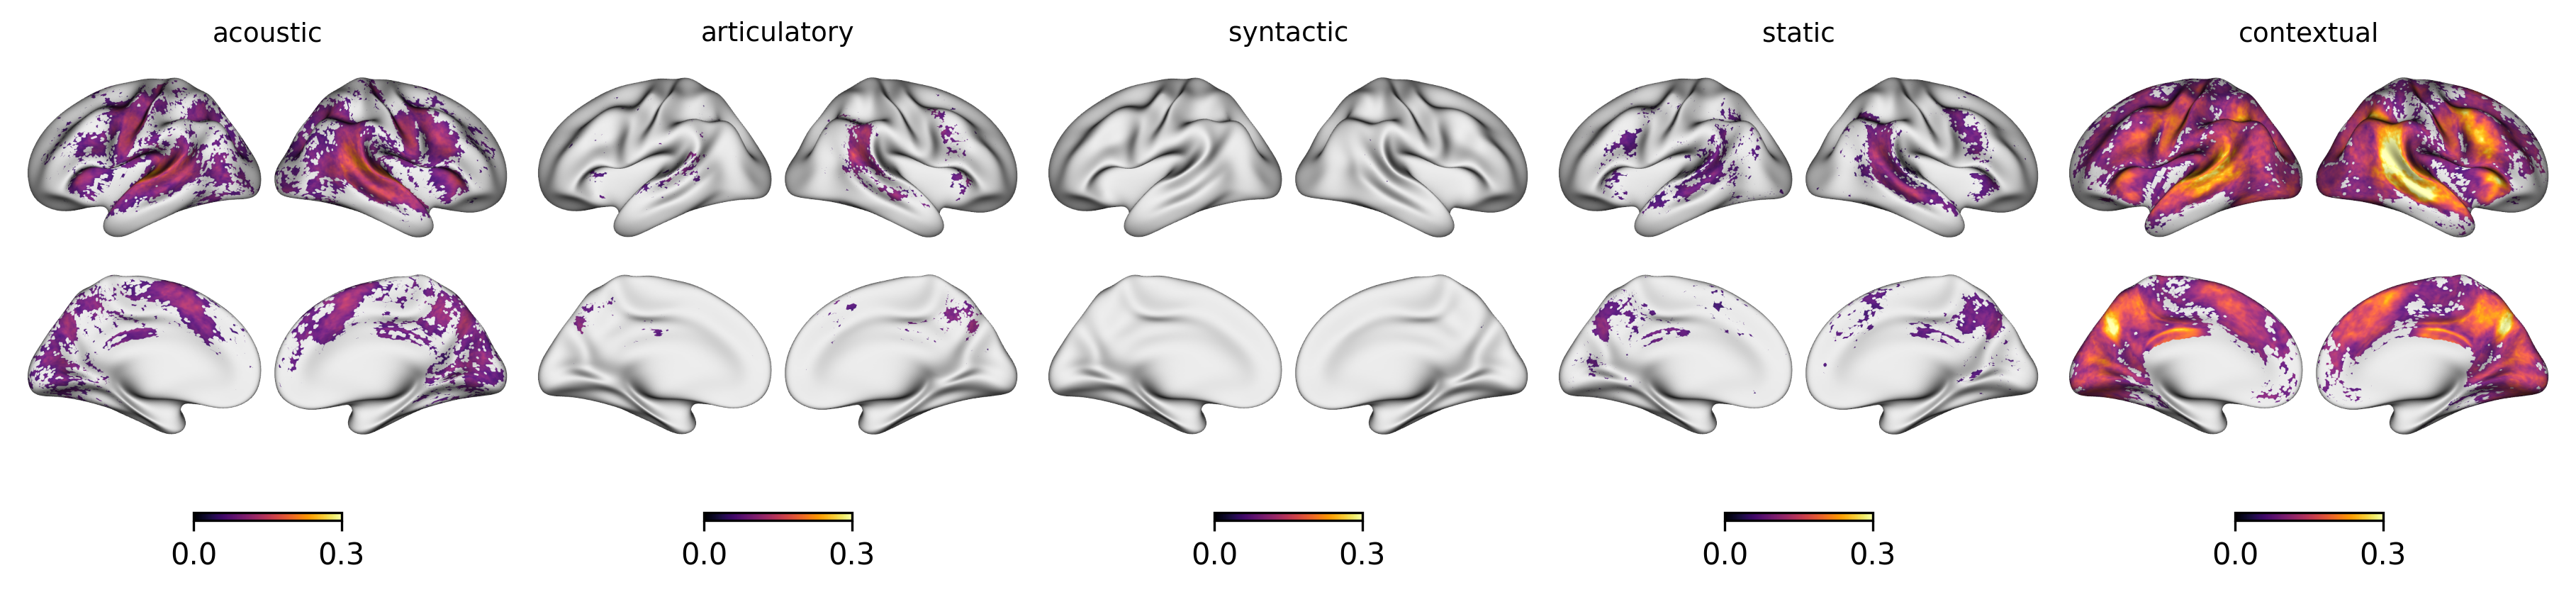

In [70]:
plot_models = models
fig, axes = plt.subplots(1, len(plot_models), figsize=(12, 4), layout='constrained', dpi=300)

# plot_models = ['static', 'contextual']
# fig, axes = plt.subplots(1, len(plot_models), figsize=(4.5, 4.5), layout='constrained', dpi=300)

sigmask = None
for modelname, ax in zip(plot_models, axes):

    values = results[modelname].mean(0)
    # values = prod_results[modelname].mean(0)
    # values = comp_results[modelname].mean(0)
    values = np.nan_to_num(values)

    sigmask = ~ stats.ttest_1samp(results[modelname], correlations=False, method='bonf', alpha=0.05)
    min = values[~sigmask].min()
    # print(modelname, min, values[~sigmask].mean())

    plot.surface_plot(values, threshold=sigmask, fig=fig, ax=ax, vmin=0.00, vmax=0.3, cmap="inferno", title=modelname)

fig.show()

## violin plot

In [7]:
data = np.stack([results[modelname][..., FG_MASK].mean(0) for modelname in model_order])
data.shape

(5, 74947)

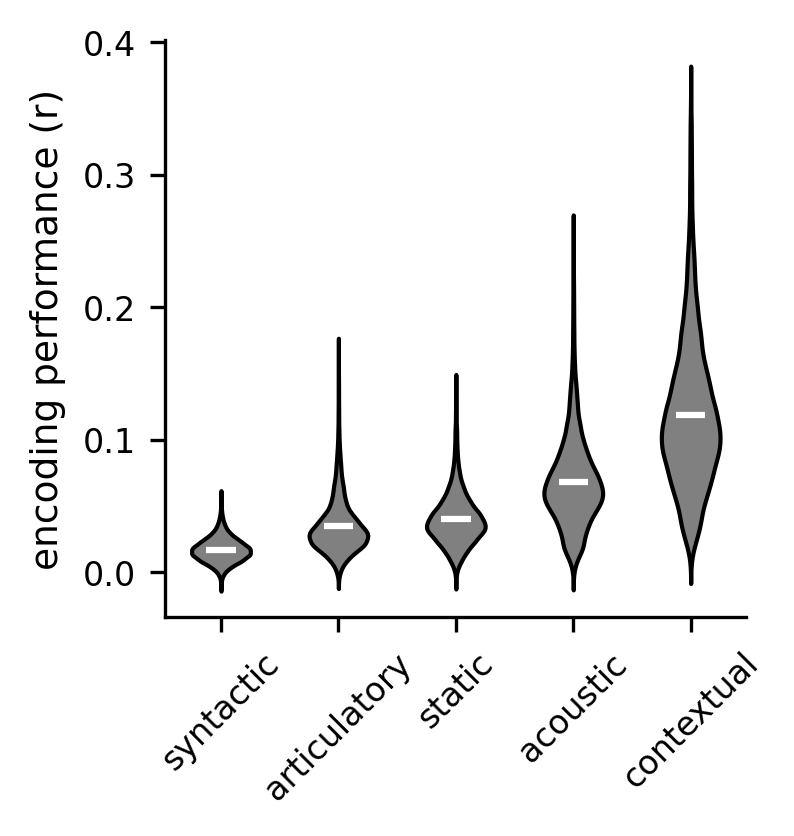

In [8]:
# https://matplotlib.org/stable/gallery/statistics/customized_violin.html
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
parts = ax.violinplot(data.T, vert=True, showmeans=True, showmedians=False, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmeans'].set_color('white')
ax.set_xticks(range(1, len(models)+1))
ax.set_xticklabels(model_order, rotation=45)
ax.set_ylabel('encoding performance (r)')
fig.show()

In [7]:
# P/C correlation
intra_pc_corr = []
for modelname in model_order:
    prod_scores = prod_results[modelname].mean(0)
    comp_scores = comp_results[modelname].mean(0)
    corr = spearmanr(prod_scores, comp_scores)
    print(modelname, corr)
    intra_pc_corr.append(corr.statistic)

syntactic SignificanceResult(statistic=0.14156705490906288, pvalue=0.0)
articulatory SignificanceResult(statistic=0.5194470814766439, pvalue=0.0)
static SignificanceResult(statistic=0.5085575811221419, pvalue=0.0)
acoustic SignificanceResult(statistic=0.7074594292250678, pvalue=0.0)
contextual SignificanceResult(statistic=0.8101492310206062, pvalue=0.0)


In [10]:
# P/C percentage overlap
intra_pc_overlap = []
for modelname in model_order:
    prod_sigmask = ttest_1samp(prod_results[modelname], correlations=False, method='fdr_bh', alpha=0.05)
    comp_sigmask = ttest_1samp(comp_results[modelname], correlations=False, method='fdr_bh', alpha=0.05)
    # overlap = (prod_sigmask & comp_sigmask).mean()
    # out of all significantly predicted voxels, how many have both?
    overlap = (prod_sigmask & comp_sigmask).sum() / (prod_sigmask + comp_sigmask).sum()
    print(modelname, overlap, prod_sigmask.mean(), comp_sigmask.mean())
    intra_pc_overlap.append(overlap)

syntactic 0.0 0.3998339924808359 0.0
articulatory 0.19883942191259493 0.7670890093257166 0.16344416776524584
static 0.4657970327815452 0.8046237976661296 0.40377667106098336
acoustic 0.6686765108012032 0.8901664957765734 0.5995923050632294
contextual 0.9563985877867719 0.9045822957863385 0.8743591621502856


## static difference

In [95]:
diff = np.mean(results['contextual'] - results['static'], axis=0)
diff.shape

(81924,)

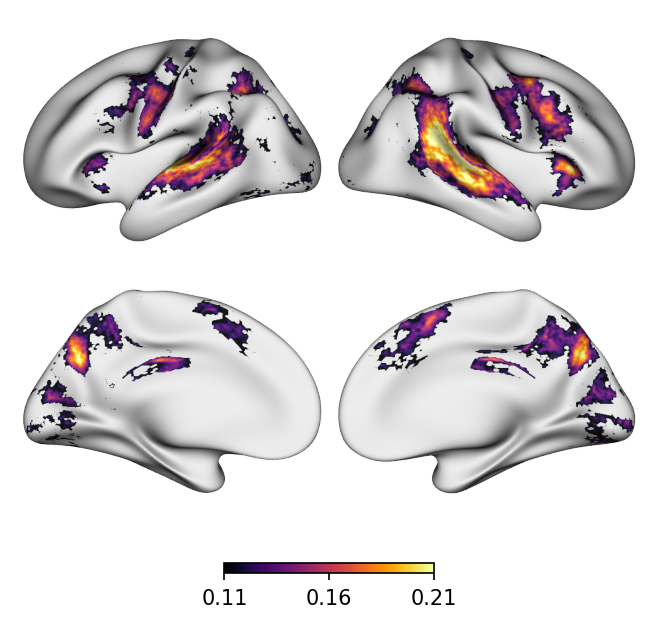

In [102]:
plot.surface_plot(diff, cmap='inferno', vmin=0.11, threshold=0.1);

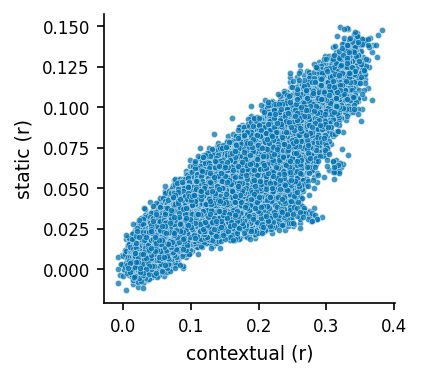

In [117]:
xvalues = results['contextual'].mean(0)[FG_MASK]
yvalues = results['static'].mean(0)[FG_MASK]

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.scatter(xvalues, yvalues, marker='.', alpha=0.75, c='gray', edgecolors='white', linewidths=0.25)
ax.set(xlabel='contextual (r)', ylabel='static (r)')
fig.show()

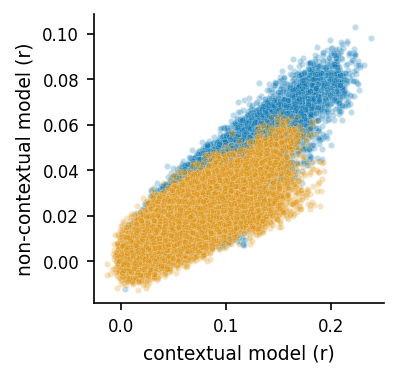

In [122]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

xvalues = prod_results['contextual'].mean(0)[FG_MASK]
yvalues = prod_results['static'].mean(0)[FG_MASK]
ax.scatter(xvalues, yvalues, marker='.', alpha=0.25, c=BLU, edgecolors='white', linewidths=0.25)

xvalues = comp_results['contextual'].mean(0)[FG_MASK]
yvalues = comp_results['static'].mean(0)[FG_MASK]
ax.scatter(xvalues, yvalues, marker='.', alpha=0.25, c=ORG, edgecolors='white', linewidths=0.25)

ax.set(xlabel='contextual model (r)', ylabel='non-contextual model (r)')
fig.show()

## variance partioning

In [39]:
models = ['joint', 'joint_syntactic']

results = defaultdict(list)
prod_results = defaultdict(list)
comp_results = defaultdict(list)
for modelname in models:
    respath = Path(
        root='results/' + encmodel,
        sub="000",
        datatype=modelname,
        ext=".hdf5",
    )

    for sub in tqdm(SUBS_STRANGERS, desc=modelname):
        respath.update(sub=f"{sub:03d}")
        if not respath.isfile():
            print("skip", sub)
            continue
        with h5py.File(respath, "r") as f:
            results[modelname].append(f['cv_scores'][:])
            # results[modelname].append(np.mean(f['cv_scores_prod'][:, -2] + f['cv_scores_comp'][:, -1], axis=0))
            # prod_results[modelname].append(np.mean(f['cv_scores_prod'][:, -2], axis=0))
            # comp_results[modelname].append(np.mean(f['cv_scores_comp'][:, -1], axis=0))

        # break

for modelname in models:
    results[modelname] = np.stack(results[modelname])
#     prod_results[modelname] = np.stack(prod_results[modelname])
#     comp_results[modelname] = np.stack(comp_results[modelname])

joint_syntactic: 100%|██████████| 58/58 [00:00<00:00, 116.03it/s]


In [40]:
full_model = np.square(results['joint'][:, :, -2:].sum(2).mean((0,1)))
nest_model = np.square(results['joint_syntactic'][:, :, -2:].sum(2).mean((0,1)))
uniq_cont = full_model - nest_model

In [42]:
np.isnan(values).sum()

0

/tmp/ipykernel_2916685/2563170478.py:2: RuntimeWarning: invalid value encountered in sqrt
  values = np.nan_to_num(np.sqrt(uniq_cont))


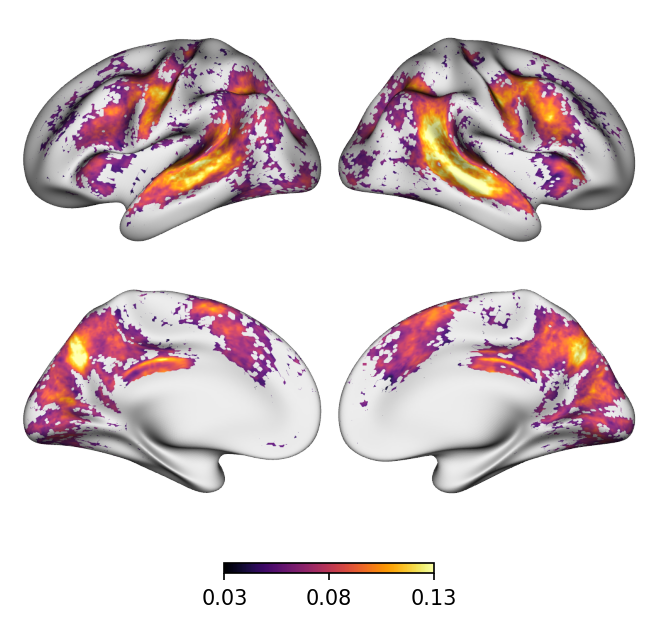

In [59]:
values = np.nan_to_num(np.sqrt(uniq_cont))
vmin = values[enc_sigmask].min()
fig = plot.surface_plot(values, cmap='inferno', vmin=vmin, threshold=~enc_sigmask)
fig.show()

# MBC comparison

In [25]:
def get_mbc(modelname:str):
    mbc_scores = defaultdict(list)

    # use subA's predictions on subB's actual neural data
    for subA in tqdm(SUBS_STRANGERS):
        # load subA preds
        encpath = Path(root='results/' + encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
        with h5py.File(encpath, "r") as f:
            prod_predA = f["cv_preds"][:, -2]  # (5, 6, 240, 81924)
            comp_predA = f["cv_preds"][:, -1]
            prodmaskA = f["cv_prodmask"][...]

        # load subB preds
        subB = subject.get_partner(subA)
        encpath = Path(root='results/' + encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
        with h5py.File(encpath, "r") as f:
            nuis_predsB = f["cv_preds"][:, :-2].sum(1)

        dataB = subject.get_bold(subB, cache=cache)
        resB = dataB.reshape(5, 240, -1) - nuis_predsB

        compmaskA = ~prodmaskA

        for i in range(5):
            mbc_scores["prod"].append(correlation_score(prod_predA[i][prodmaskA[i]], resB[i][prodmaskA[i]]))
            mbc_scores["comp"].append(correlation_score(comp_predA[i][compmaskA[i]], resB[i][compmaskA[i]]))

    sub_mbc_prod = np.stack(mbc_scores["prod"])
    sub_mbc_comp = np.stack(mbc_scores["comp"])
    
    return sub_mbc_prod, sub_mbc_comp

In [127]:
models = ['acoustic', 'articulatory', 'syntactic', 'static', 'contextual']

results = []
for modelname in models:
    results.append(get_mbc(modelname))

100%|██████████| 58/58 [03:30<00:00,  3.64s/it]


In [128]:
# save
with h5py.File(f"{cachedir}/mbc.hdf5", "w") as f:
    for modelname, (prod, comp) in zip(models, results):
        f.create_dataset(name=f'{modelname}_prod', data=prod)
        f.create_dataset(name=f'{modelname}_comp', data=comp)

In [8]:
# read
results = []
with h5py.File(f"{cachedir}/mbc.hdf5", "r") as f:
    for modelname in models:
        results.append((f[f'{modelname}_prod'][...], f[f'{modelname}_comp'][...]))

In [20]:
data = []
for i, modelname, result in zip(range(len(models)), models, results):
    values = (result[0] + result[1]) / 2
    data.append(values[..., FG_MASK])
data = np.stack(data).mean(1)
data.shape

(5, 74947)

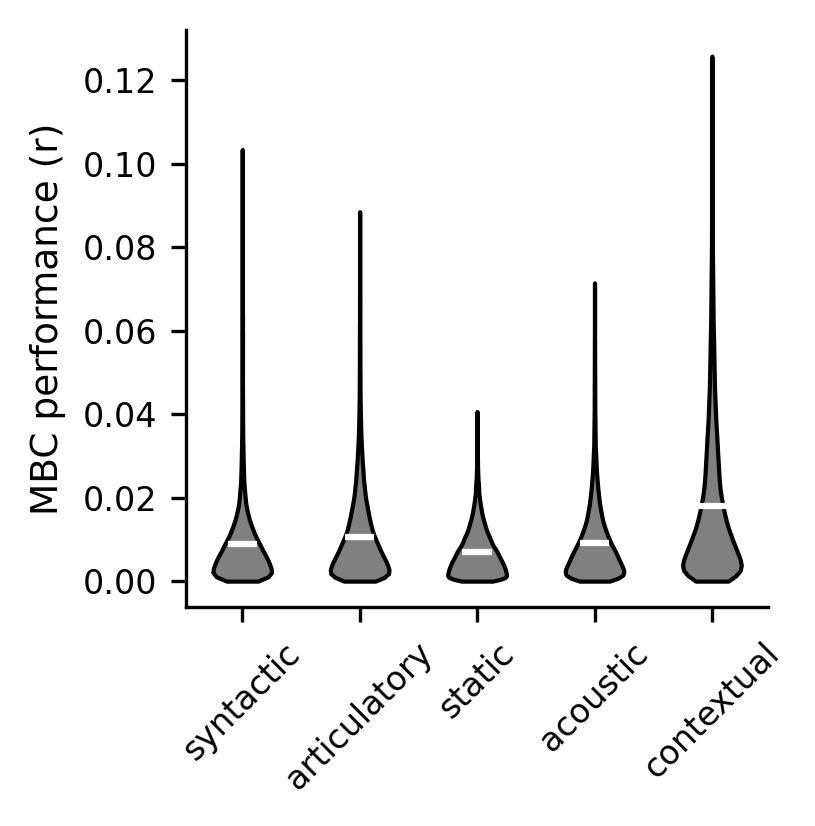

In [23]:
# https://matplotlib.org/stable/gallery/statistics/customized_violin.html
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
parts = ax.violinplot(np.abs(data.T), vert=True, showmeans=True, showmedians=False, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmeans'].set_color('white')
ax.set_xticks(range(1, len(models)+1))
ax.set_xticklabels(model_order, rotation=45)
ax.set_ylabel('MBC performance (r)')
fig.show()

In [10]:
# P/C correlation
inter_pc_corr = []
for i, modelname, result in zip(range(len(models)), models, results):
    corr = spearmanr(result[0].mean(0), result[1].mean(0))
    print(modelname, corr)
    inter_pc_corr.append(corr.statistic)

acoustic SignificanceResult(statistic=0.48268325579306454, pvalue=0.0)
articulatory SignificanceResult(statistic=0.6421874475678558, pvalue=0.0)
syntactic SignificanceResult(statistic=0.4618144461046909, pvalue=0.0)
static SignificanceResult(statistic=0.7236131805301309, pvalue=0.0)
contextual SignificanceResult(statistic=0.8144783450777355, pvalue=0.0)


In [21]:
inter_pc_overlap = []
for i, modelname, result in zip(range(len(models)), models, results):
    values = (result[0] + result[1]) / 2
    sigmask = stats.ttest_1samp(values, method='fdr_by', alpha=0.05)
    overlap = sigmask.mean()
    print(modelname, overlap)
    inter_pc_overlap.append(overlap)

acoustic 0.247678527405703
articulatory 0.46760895170789163
syntactic 0.17084394773605063
static 0.366368093790232
contextual 0.7773029829895637


In [63]:
# P/C percentage overlap out of all voxels
intra_pc_overlap = []
inter_pc_overlap = []
for i, modelname, result in zip(range(len(models)), model_order, results):
    prod_sigmask = ttest_1samp(prod_results[modelname], correlations=False, method='fdr_bh', alpha=0.05)
    comp_sigmask = ttest_1samp(comp_results[modelname], correlations=False, method='fdr_bh', alpha=0.05)

    # out of all significantly predicted voxels, how many have both?
    overlap = (prod_sigmask & comp_sigmask).sum() / (prod_sigmask + comp_sigmask).sum()
    # overlap = (prod_sigmask & comp_sigmask).mean()  # out of all voxels
    intra_pc_overlap.append(overlap)

    values = (result[0] + result[1]) / 2
    sigmask = stats.ttest_1samp(values, method='fdr_bh', alpha=0.05)
    overlap = sigmask.sum() / (prod_sigmask + comp_sigmask).sum()
    # overlap = sigmask.mean()
    inter_pc_overlap.append(overlap)

    print(modelname, intra_pc_overlap[-1], inter_pc_overlap[-1])

syntactic 0.0 0.5297655391378678
articulatory 0.19883942191259493 0.4202928179402098
static 0.4657970327815452 0.22233409339927152
acoustic 0.6686765108012032 0.3137134263057151
contextual 0.9563985877867719 0.5052689514451022


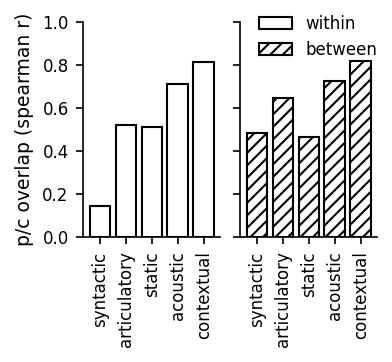

In [15]:
# P/C percentage overlap out of all voxels
x = np.arange(len(model_order))  # the label locations
width = 0.8  # the width of the bars

fig, axes = plt.subplots(1, 2, figsize=(2.5, 2.3), layout='constrained', sharex=False, sharey=True)

colors = ['w', 'w']
hatches = [None, '////']
labels = ['within', 'between']
# datums = (intra_pc_overlap, inter_pc_overlap)
datums = (intra_pc_corr, inter_pc_corr)

for ax, attribute, measurement, color, hatch in zip(axes, labels, datums, colors, hatches):
    ax.bar(x + width, measurement, width, label=attribute, hatch=hatch, facecolor=color, edgecolor='black')
    ax.set_xticks(x + width, model_order)
    ax.set_xticklabels(model_order, rotation=90)

fig.legend(loc='upper right', ncols=1)
axes[0].set_ylim(0, 1)
# axes[0].set_ylabel('overlap (% voxels)')
axes[0].set_ylabel('p/c overlap (spearman r)')
plt.show()

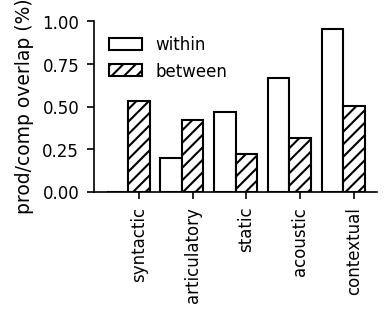

In [69]:
# P/C percentage overlap out of all sig voxels within each model
x = np.arange(len(model_order))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(2.5, 2), layout='constrained')

colors = ['w', 'w']
hatches = [None, '////']
labels = ['within', 'between']
datums = (intra_pc_overlap, inter_pc_overlap)

multiplier = 0
for attribute, measurement, color, hatch in zip(labels, datums, colors, hatches):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, hatch=hatch, facecolor=color, edgecolor='black')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('prod/comp overlap (%)')
ax.set_xticks(x + width, model_order)
ax.set_xticklabels(model_order, rotation=90)
ax.legend(loc='upper left', ncols=1)

plt.show()

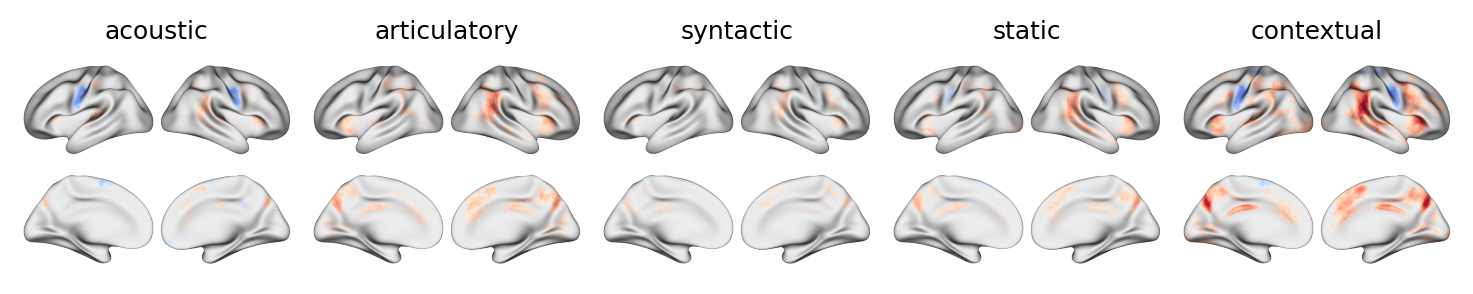

In [133]:
fig, axes = plt.subplots(1, len(models), figsize=(7.25, 6), layout='constrained', dpi=200)

for i, modelname, result, ax in zip(range(len(models)), models, results, axes):
    values = (result[0] + result[1]) / 2
    sigmask = ~ stats.ttest_1samp(values, method='fdr_by', alpha=0.05)
    plot.surface_plot(values.mean(0), threshold=sigmask, fig=fig, ax=ax, vmax=0.1, cmap="coolwarm", title=modelname, cbar=False)

fig.show()

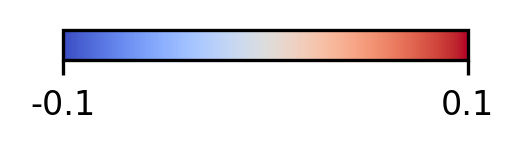

In [134]:
fig = plot.standalone_colorbar('coolwarm', tick_labels=(-0.1, 0.1))
fig.show()

## variance partitioning

In [26]:
models = ['joint', 'joint_syntactic']

results = []
for modelname in models:
    results.append(get_mbc(modelname))

100%|██████████| 58/58 [06:25<00:00,  6.65s/it]


TypeError: list indices must be integers or slices, not str

In [27]:
# save
with h5py.File(f"{cachedir}/mbc-vp.hdf5", "w") as f:
    for modelname, (prod, comp) in zip(models, results):
        f.create_dataset(name=f'{modelname}_prod', data=prod)
        f.create_dataset(name=f'{modelname}_comp', data=comp)

In [63]:
# read
results = []
with h5py.File(f"{cachedir}/mbc-vp.hdf5", "r") as f:
    for modelname in models:
        results.append((f[f'{modelname}_prod'][...], f[f'{modelname}_comp'][...]))

<KeysViewHDF5 ['joint_comp', 'joint_prod', 'joint_syntactic_comp', 'joint_syntactic_prod']>


In [64]:
res = {}
res['joint'] = (results[0][0] + results[0][1]) / 2
res['joint_syntactic'] = (results[1][0] + results[1][1]) / 2

In [65]:
full_model = np.square(res['joint'].mean(0))
nest_model = np.square(res['joint_syntactic'].mean(0))
uniq_cont = full_model - nest_model

/tmp/ipykernel_2916685/4148431946.py:1: RuntimeWarning: invalid value encountered in sqrt
  values = np.nan_to_num(np.sqrt(uniq_cont))


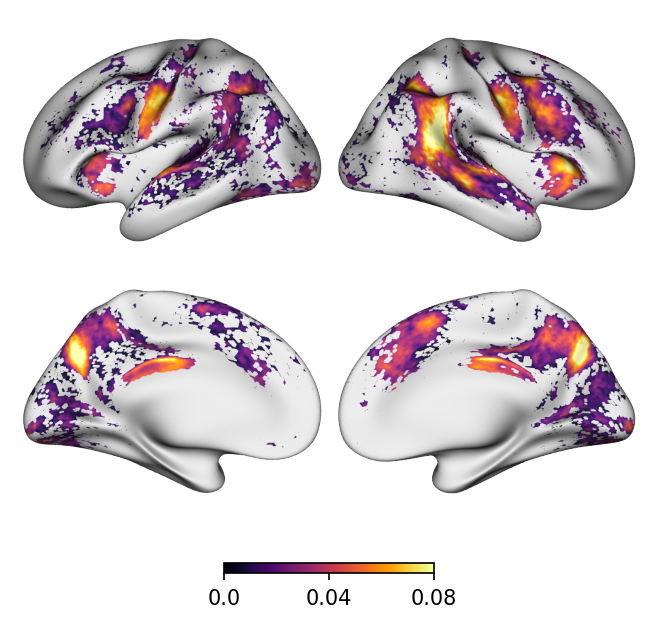

In [66]:
values = np.nan_to_num(np.sqrt(uniq_cont))
vmin = values[enc_sigmask].min()
fig = plot.surface_plot(values, cmap='inferno', vmin=vmin, threshold=~enc_sigmask)
fig.show()

/tmp/ipykernel_2916685/2669043552.py:1: RuntimeWarning: invalid value encountered in sqrt
  values = np.nan_to_num(np.sqrt(uniq_cont))


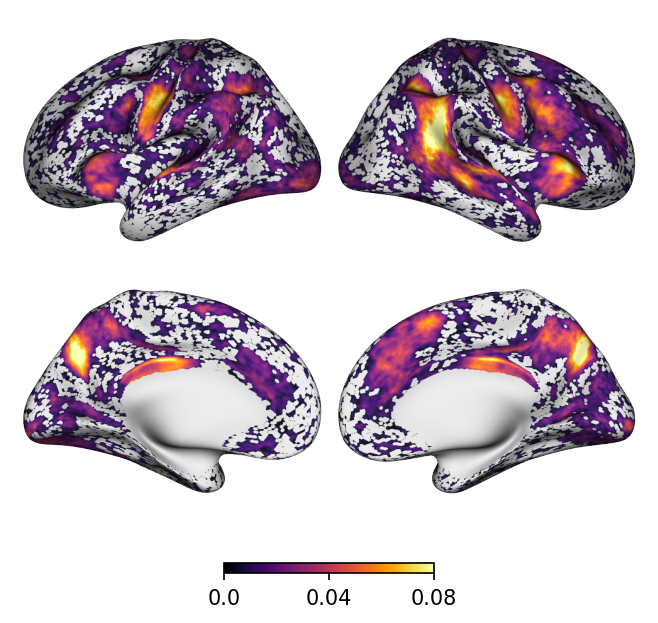

In [38]:
values = np.nan_to_num(np.sqrt(uniq_cont))
fig = plot.surface_plot(values, cmap='inferno', vmin=0)#, vmin=0.07, threshold=0.07)
fig.show()